## Imports

In [2]:
%matplotlib inline

from osgeo import osr, gdal

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

import re

sns.set(color_codes=True)

## Read location of Coco Trees

In [3]:
coco_tree = pd.read_csv('../data/tree_coconuts/locations.json', index_col=0)
coco_tree

,x,y
0,-175.338616,-21.087592
1,-175.338541,-21.089580
2,-175.337749,-21.088268
3,-175.337780,-21.088143
4,-175.337803,-21.088248
5,-175.338165,-21.088149
6,-175.338028,-21.087524
7,-175.338004,-21.087576
8,-175.337944,-21.087596
9,-175.338017,-21.087675


## Reading Image

In [4]:
datafile = gdal.Open("../data/aerial_image/kolovai.tif")
bnd1 = datafile.GetRasterBand(1).ReadAsArray()
bnd2 = datafile.GetRasterBand(2).ReadAsArray()
bnd3 = datafile.GetRasterBand(3).ReadAsArray()
nx = datafile.RasterXSize # Raster xsize
ny = datafile.RasterYSize # Raster ysize

img = np.dstack((bnd1, bnd2, bnd3))

### Retrieve Latitude and Longitude of Image

In [13]:
old_cs= osr.SpatialReference()
old_cs.ImportFromWkt(datafile.GetProjectionRef())

# create the new coordinate system
wgs84_wkt = """
GEOGCS["WGS 84",
    DATUM["WGS_1984",
        SPHEROID["WGS 84",6378137,298.257223563,
            AUTHORITY["EPSG","7030"]],
        AUTHORITY["EPSG","6326"]],
    PRIMEM["Greenwich",0,
        AUTHORITY["EPSG","8901"]],
    UNIT["degree",0.01745329251994328,
        AUTHORITY["EPSG","9122"]],
    AUTHORITY["EPSG","4326"]]"""
new_cs = osr.SpatialReference()
new_cs.ImportFromWkt(wgs84_wkt)

# create a transform object to convert between coordinate systems
transform = osr.CoordinateTransformation(old_cs, new_cs) 

#get the point to transform, pixel (0,0) in this case
W = datafile.RasterXSize
H = datafile.RasterYSize
gt = datafile.GetGeoTransform()
minx = gt[0]
miny = gt[3] + W*gt[4] + H*gt[5] 
maxx = gt[0] + W*gt[1] + H*gt[2]
maxy = gt[3]

#get the coordinates in lat long
xgeo0, ygeo0, _ = transform.TransformPoint(minx, miny)
xgeoN, ygeoN, _ = transform.TransformPoint(maxx, maxy)

In [66]:
print(xgeo0, ygeo0)
print(xgeoN, ygeoN)

-175.34907207131698 -21.104930856349313
-175.33536665317192 -21.08692801644621


## Process and Chunk

### Coordinate Converter and Image Chunker

In [70]:
class Converter:
    def __init__(self, geo0, geoN, img_shape):
        self.xgeo0, self.ygeo0 = geo0
        self.xgeoN, self.ygeoN = geoN
        self.H, self.W = img_shape
        print(img_shape)
    
    def geo_2_pixel(self, x, y):
        x_pix = ((x - self.xgeo0)/abs(self.xgeoN - self.xgeo0)) * self.W
        y_pix = ((y - self.ygeo0)/abs(self.ygeoN - self.ygeo0)) * self.H
        
        return int(round(x_pix)), int(round(y_pix))

class ImageChunker:
    def __init__(self, img, img_shape):
        self.img = img
        self.H, self.W = img_shape
    
    def chunk(self, x, y, d):
        if x < 0 or x > self.W or y < 0 or y > self.H:
            return (None, None)
        
        x_start = x - d
        
        if x_start < 0:
            d = x
            return self.chunk(x, y, d)
        
        x_end = x + d
        
        if x_end > self.W:
            d = self.W - x
            return self.chunk(x, y, d)
        
        y_start = y - d
        
        if y_start < 0:
            d = y
            return self.chunk(x, y, d)
        
        y_end = y + d
        
        if y_end > self.H:
            d = self.H - y
            return self.chunk(x, y, d)
        
        return (self.img[y_start: y_end, x_start: x_end], d)

### Display Image Segment

In [79]:
def display_segment(loc_conv, handle_img, loc):
    x, y = loc_conv.geo_2_pixel(loc[0], loc[1])
    print(x,y)
    res = handle_image.chunk(x, y, 100)
    if res[0] is not None:
        print(res[1])
        fig = plt.figure(figsize=(10,10))
        plt.imshow(res[0])
        plt.show()
    else:
        print("Image Error!\n\n")

### Iterate and Display some Images

(25006, 17761)
10274 19742
100


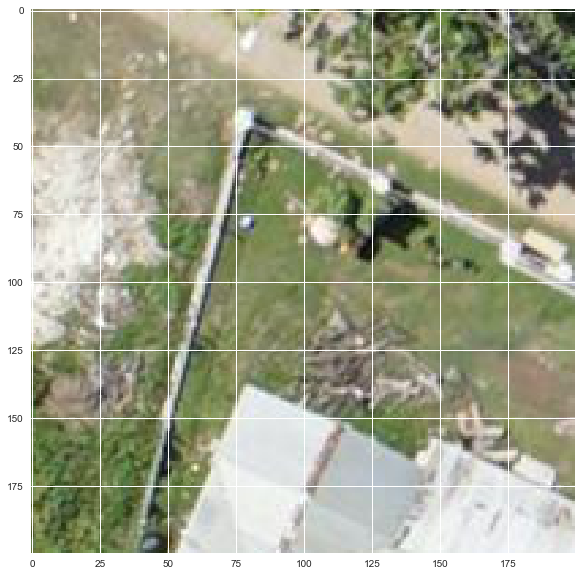

1526 23222
100


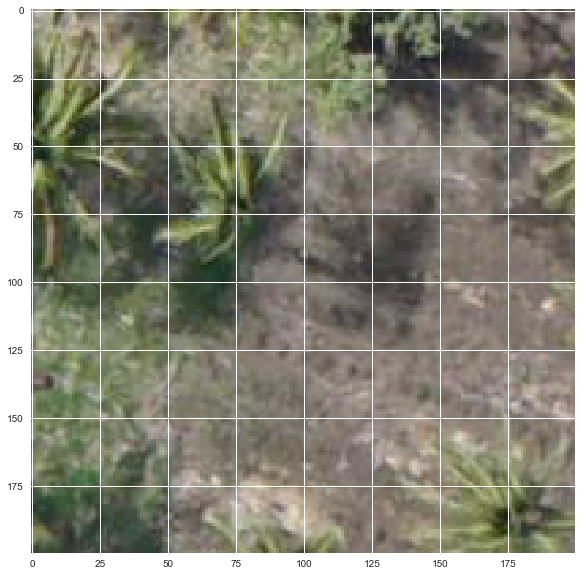

4085 17437
100


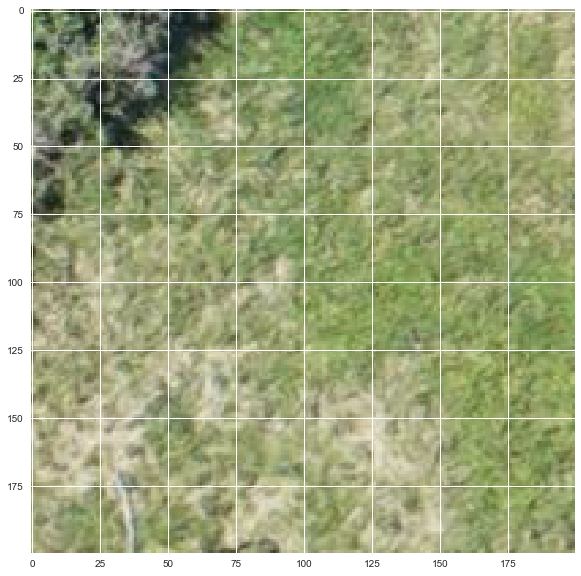

11781 19492
100


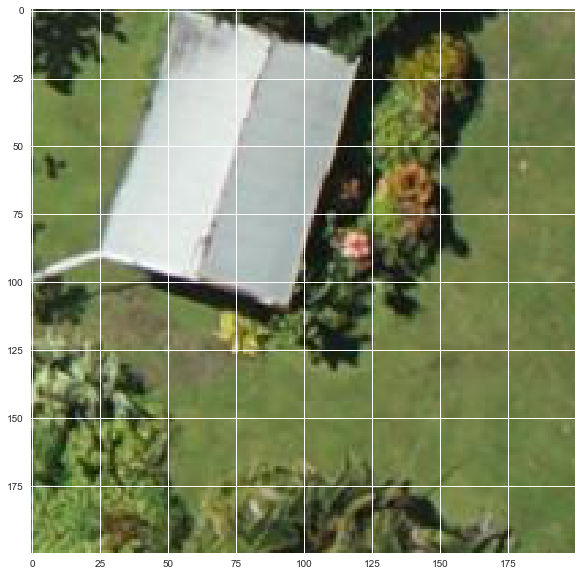

637 1751
100


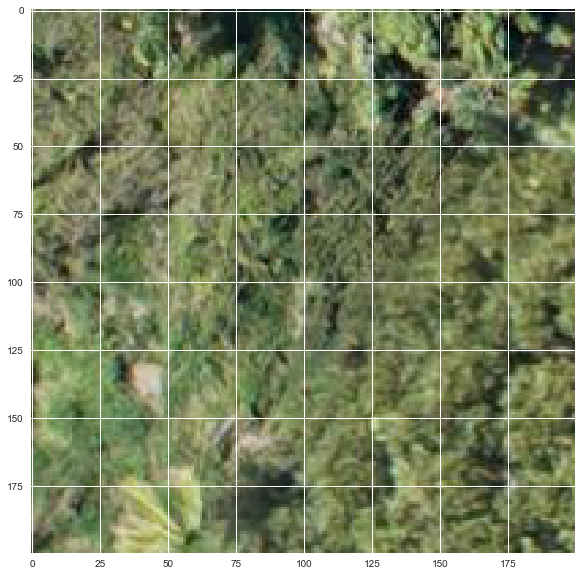

5829 8160
100


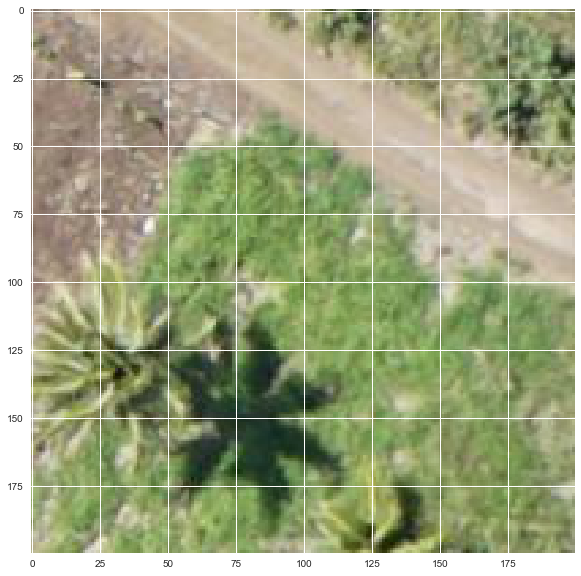

17 15834
17


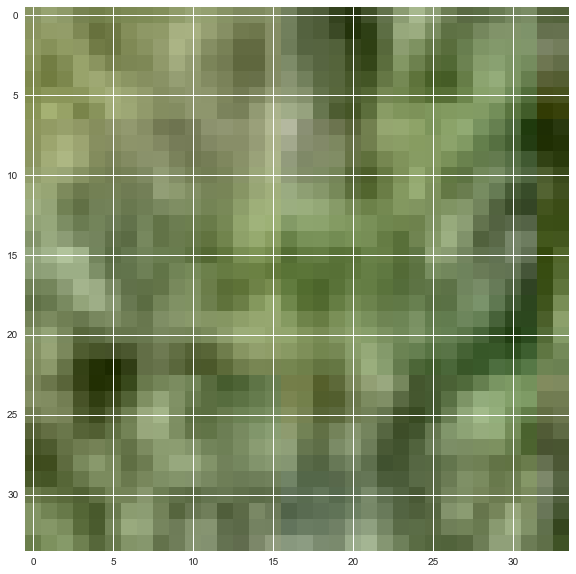

8589 4950
100


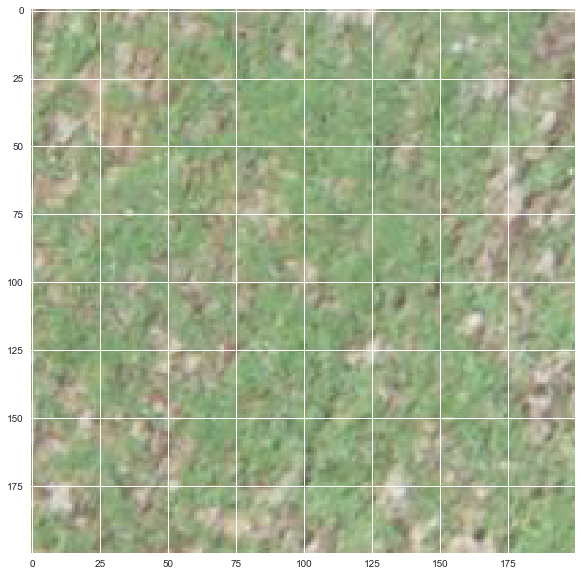

1926 624
100


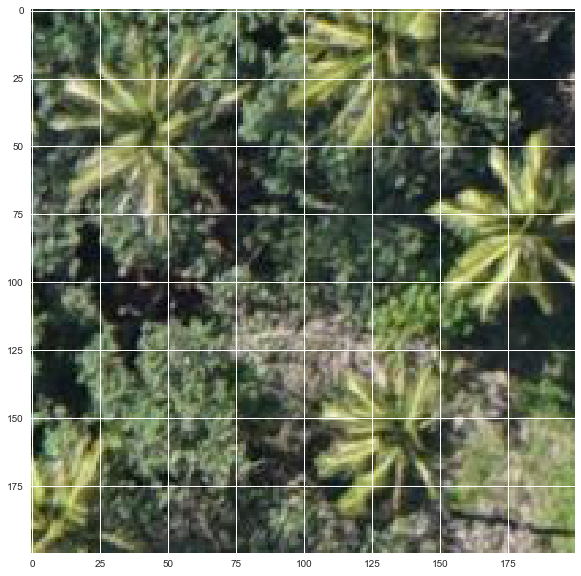

5965 8543
100


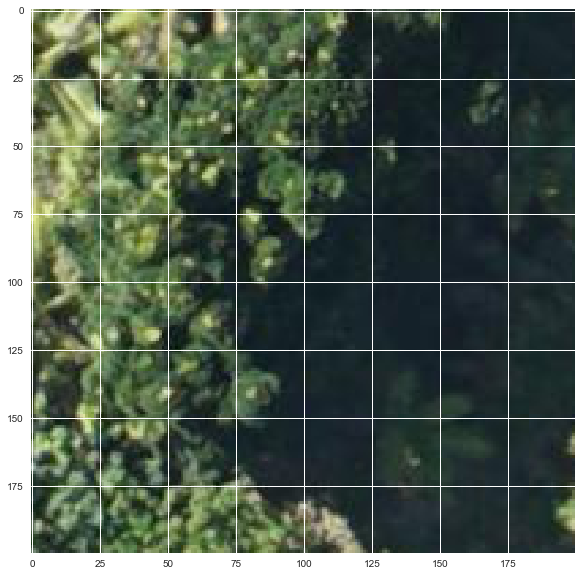

6676 4652
100


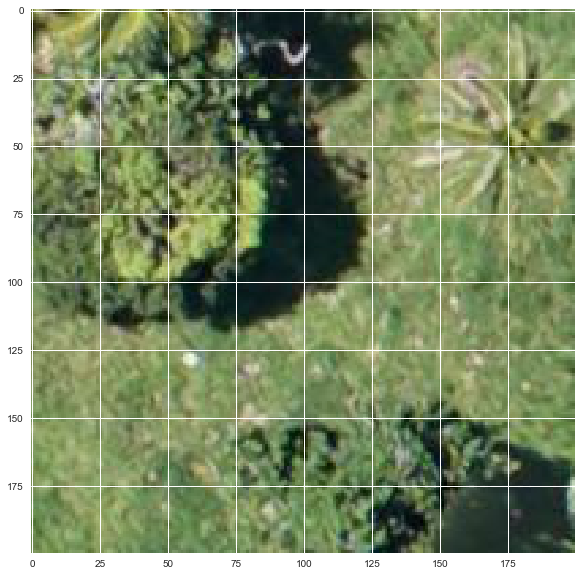

12013 22895
100


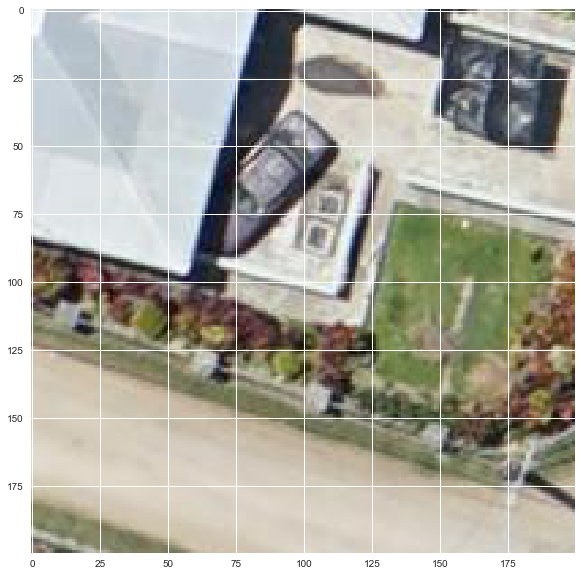

3179 9220
100


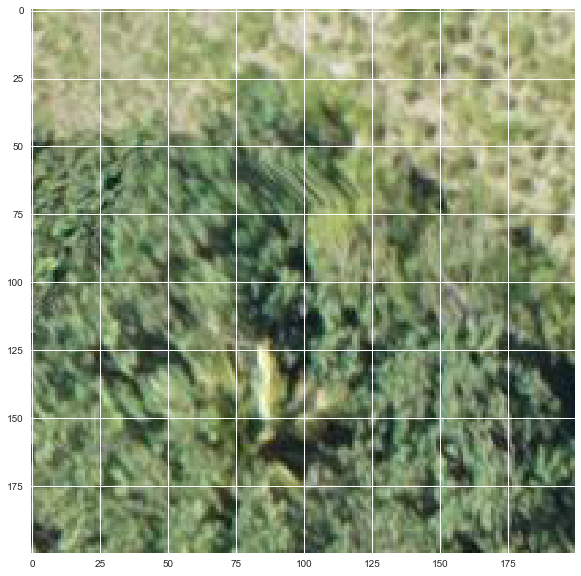

1901 14588
100


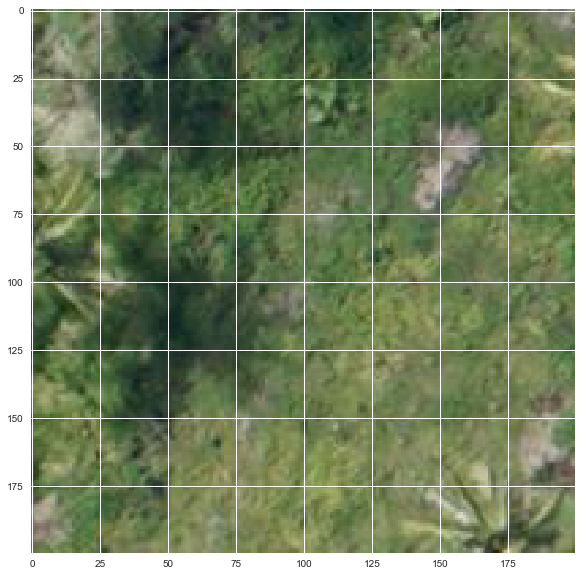

13038 24089
100


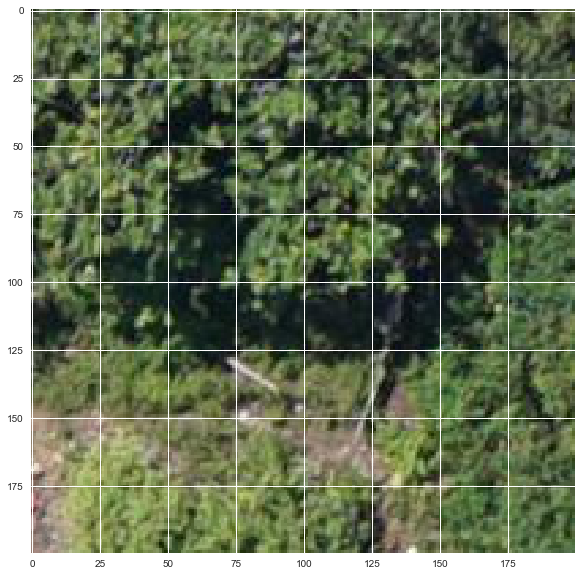

In [80]:
loc_converter = Converter((xgeo0, ygeo0), (xgeoN, ygeoN), img.shape[:2])
handle_image = ImageChunker(img, img.shape[:2])

for index, row in coco_tree.sample(15).iterrows():
    display_segment(loc_converter, handle_image, (row['x'], row['y']))